In [20]:
from foundry.util.runtime import setup
setup()

from image_diffusion.main import logger
logger.setLevel('INFO')

import foundry.core as F
import foundry.random
import foundry.numpy as npx
import foundry.train

from foundry.train import LossOutput
from foundry.models.embed import SinusoidalPosEmbed
from foundry.models import activation
from foundry.random import PRNGSequence
from foundry.data import PyTreeData
from foundry.diffusion.ddpm import DDPMSchedule
from foundry.core import tree
from foundry.core.dataclasses import dataclass, replace
import foundry.diffusion.nonparametric as nonparametric

import flax.linen as nn
import flax.linen.activation as activations

import rich
import jax
import optax
import foundry.train.console
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
import foundry.util.serialize
import wandb
import sklearn.metrics
import chex


from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from sklearn.linear_model import LinearRegression

from typing import Sequence
from functools import partial

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})

In [2]:
def r2_scatter(ax, x, y, loc=None, log_xscale=False, **kwargs):
    model = LinearRegression()
    if log_xscale: x_reg = npx.log(x)
    else: x_reg = x
    model.fit(x_reg.reshape(-1, 1), y)
    y_pred = model.predict(x_reg.reshape(-1, 1))
    r2 = sklearn.metrics.r2_score(y, y_pred)

    h = ax.scatter(x, y, **kwargs)

    x0, x1 = ax.get_xaxis().get_view_interval()
    if log_xscale: 
        x0 = npx.maximum(x0, 1e-4)
        x0_reg, x1_reg = npx.log(npx.array([x0, x1]))
    else: 
        x0_reg, x1_reg = x0, x1

    y0, y1 = model.predict(((x0_reg,),))[0], model.predict(((x1_reg,),))[0]

    ax.add_line(plt.Line2D((x0, x1), (y0, y1), color="black", linestyle="--", linewidth=1))
    loc = (0.3, 0.3) if loc is None else loc
    ax.text(loc[0], loc[1], f"$r^2 = { r2 : 0.02}$", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    return h

In [3]:
def mnist_plots():
    MNIST_COLORMAP = {
        0: "#E52B50",
        1: "#9F2B68",
        2: "#3B7A57",
        3: "#3DDC84",
        4: "#FFBF00",
        5: "#915C83",
        6: "#008000",
        7: "#7FFFD4",
        8: "#E9D66B",
        9: "#007FFF",
    }

    api = wandb.Api()
    artifact = api.artifact("dpfrommer-projects/image-diffusion-eval/evaluation:v44")
    entries = list(artifact.files())
    data_url = entries[-1]._attrs["directUrl"]
    eval_data = foundry.util.serialize.load(data_url)
    checkpoint_url = eval_data.checkpoint_uri
    checkpoint = foundry.util.serialize.load(checkpoint_url)

    model = checkpoint.config.create()
    schedule = checkpoint.schedule
    vars = checkpoint.vars
    normalizer, train_data, test_data = checkpoint.create_data()
    train_data = jax.vmap(normalizer.normalize)(train_data.as_pytree())
    test_data = jax.vmap(normalizer.normalize)(test_data.as_pytree())
    latents = test_data.cond

    def embed_scatter(ax, zs, labels, **kwargs):
        colors = [MNIST_COLORMAP[label.item()] for label in labels]
        ax.scatter(zs[:, 0], zs[:, 1], c=colors, s=5, **kwargs)

    def map(f, batch_size=None):
        return lambda *x: jax.lax.map(lambda x: f(*x), x, batch_size=batch_size)

    def smoothing_eval(xs, ys, vals, radius=1/32):
        x_min, x_max = npx.min(xs), npx.max(xs)
        y_min, y_max = npx.min(ys), npx.max(ys)
        x_bw, y_bw = (x_max - x_min)*radius, (y_max - y_min)*radius

        def eval(x, y):
            dists_sqr = (xs - x)**2/(x_bw**2) + (ys - y)**2/(y_bw**2)
            log_kernel = -dists_sqr
            log_kernel = log_kernel - jax.scipy.special.logsumexp(log_kernel)
            return npx.exp(jax.scipy.special.logsumexp(log_kernel, b=vals))
        return eval

    def smoothed_colormesh(ax, eval, *, 
            x_min, x_max, y_min, y_max,
            val_clip=None, **kwargs):
        xs_high = npx.linspace(x_min, x_max, 256)
        ys_high = npx.linspace(y_min, y_max, 256)
        XS_high, YS_high = npx.meshgrid(xs_high, ys_high)
        vals_high = map(map(eval, batch_size=4), batch_size=4)(XS_high, YS_high)
        if val_clip is not None:
            vals_high = vals_high.clip(-val_clip, val_clip)
        # plt.scatter(xs, ys, c=vals, **kwargs)
        return ax.pcolormesh(xs_high, ys_high, vals_high, **kwargs, rasterized=True)

    def latent_density(x):
        sigma = 0.2
        log_density = -npx.sum(npx.square(latents - x), axis=-1)/(2*sigma**2)
        N = log_density.shape[0]
        log_density = jax.scipy.special.logsumexp(log_density)
        log_norm = 1/2*npx.log(2*npx.pi) + npx.log(sigma) + npx.log(N)
        return npx.exp(log_density - log_norm)

    def mnist_si_heatmap(fig, ax, nw_error=True):
        mesh = smoothed_colormesh(ax,
            smoothing_eval(
                eval_data.cond[:,0], 
                eval_data.cond[:,1], 
                npx.mean(eval_data.nw_error),
                radius=1/64
            ),
            x_min=-2.4, x_max=2.4,
            y_min=-2.4, y_max=2.4,
            val_clip=12,
            cmap="Greys"
        )
        ax.set_ylim(-2.4, 2.4)
        ax.set_xlim(-2.4, 2.4)
        ax.set_xlabel("t-SNE First Component")
        ax.set_ylabel("t-SNE Second Component")
        cbar = fig.colorbar(mesh)
        cbar.set_label("Schedule Inconsistency")
        embed_scatter(ax, latents[::2], test_data.label[::2], alpha=0.1)
        return mesh, cbar

    def mnist_si_heatmap(fig, ax):
        mesh = smoothed_colormesh(ax,
            smoothing_eval(
                eval_data.cond[:,0], 
                eval_data.cond[:,1], 
                eval_data.nw_error,
                radius=1/64
            ),
            x_min=-2.4, x_max=2.4,
            y_min=-2.4, y_max=2.4,
            cmap="Greys"
        )
        ax.set_ylim(-2.4, 2.4)
        ax.set_xlim(-2.4, 2.4)
        ax.set_xlabel("t-SNE First Component")
        ax.set_ylabel("t-SNE Second Component")
        cbar = fig.colorbar(mesh)
        cbar.set_label("DDIM/DDPM OT Distance")
        embed_scatter(ax, latents[::2], test_data.label[::2], alpha=0.1)

    def mnist_ot_heatmap(fig, ax):
        mesh = smoothed_colormesh(ax,
            smoothing_eval(
                eval_data.cond[:,0], 
                eval_data.cond[:,1], 
                eval_data.ott_cost,
                radius=1/64
            ),
            x_min=-2.4, x_max=2.4,
            y_min=-2.4, y_max=2.4,
            cmap="Greys"
        )
        ax.set_ylim(-2.4, 2.4)
        ax.set_xlim(-2.4, 2.4)
        ax.set_xlabel("t-SNE First Component")
        ax.set_ylabel("t-SNE Second Component")
        cbar = fig.colorbar(mesh)
        cbar.set_label("DDIM/DDPM OT Distance")
        embed_scatter(ax, latents[::2], test_data.label[::2], alpha=0.1)

    
    def mnist_density_si_scatter(ax, **kwargs):
        Xs, Ys = latents[::10].T
        x = F.vmap(latent_density)(npx.stack((Xs, Ys), -1))
        y = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            (eval_data.nw_error).mean(-1),
            radius=1/64
        ))(Xs, Ys)
        scatter = r2_scatter(ax, x, y, **kwargs)
        return scatter
    
    def mnist_density_ot_scatter(ax, **kwargs):
        Xs, Ys = latents[::10].T
        x = F.vmap(latent_density)(npx.stack((Xs, Ys), -1))
        y = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            eval_data.ott_cost,
            radius=1/64
        ))(Xs, Ys)
        scatter = r2_scatter(ax, x, y, **kwargs)
        return scatter

    def mnist_density_ot_scatter(ax, **kwargs):
        Xs, Ys = latents[::10].T
        x = F.vmap(latent_density)(npx.stack((Xs, Ys), -1))
        y = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            eval_data.ott_cost,
            radius=1/64
        ))(Xs, Ys)
        scatter = r2_scatter(ax, x, y, **kwargs)
        return scatter
    
    def mnist_si_ot_scatter(ax, **kwargs):
        Xs, Ys = latents[::10].T
        x = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            (eval_data.nw_error).mean(-1),
            radius=1/64
        ))(Xs, Ys)
        y = F.vmap(smoothing_eval(
            eval_data.cond[:,0], 
            eval_data.cond[:,1], 
            eval_data.ott_cost,
            radius=1/64
        ))(Xs, Ys)
        scatter = r2_scatter(ax, x, y, **kwargs)
        return scatter

    return (
        mnist_si_heatmap, mnist_density_si_scatter,
        mnist_ot_heatmap, mnist_density_ot_scatter,
        mnist_si_ot_scatter
    )

In [25]:
@dataclass
class DPData:
    density: jax.Array
    ot: jax.Array
    var: jax.Array
    si: jax.Array
    
def dp_data():
    from policy_eval.common import Result
    from policy_eval.methods.diffusion_policy import Checkpoint
    api = wandb.Api()
    artifact = api.artifact("dpfrommer-projects/policy-eval/final_result:v59")
    checkpoint_ref = list(artifact.files())[-1]._attrs["directUrl"]
    checkpoint : Checkpoint = Result.load_s3(checkpoint_ref)

    env, splits = checkpoint.data.load({"test", "train"})
    train_data = splits["train"].as_pytree()
    test_data = splits["test"].as_pytree()
    denoiser = checkpoint.create_denoiser()
    obs_normalizer = checkpoint.obs_normalizer
    act_normalizer = checkpoint.action_normalizer
    schedule = checkpoint.schedule

    test_obs = tree.map(lambda x: x[::3], train_data.observations)
    test_actions = tree.map(lambda x: x[::3], train_data.actions)
    indices = foundry.random.permutation(foundry.random.key(42), tree.axis_size(test_obs))
    test_obs = tree.map(lambda x: x[indices], test_obs)
    test_actions = tree.map(lambda x: x[indices], test_actions)

    @jax.jit
    def measure_variance(rng_key, obs):
        def measure_var(inputs):
            rng_key, obs = inputs
            def do_sample(rng_key, eta=1.0):
                obs_normalized = obs_normalizer.normalize(obs)
                action = schedule.sample(rng_key, partial(denoiser, obs_normalized), 
                                            act_normalizer.structure, eta=eta)
                return action
            do_sample = jax.vmap(do_sample, in_axes=(0, None))
            rng_key, s_rng = jax.random.split(rng_key, 2)
            ddpm_samples = do_sample(jax.random.split(s_rng, 128), 0.0)
            ddpm_samples = ddpm_samples.reshape((ddpm_samples.shape[0], -1))
            ddpm_samples = ddpm_samples - npx.mean(ddpm_samples, axis=0)[None, :]
            ddpm_samples = npx.mean(npx.sum(npx.square(ddpm_samples), axis=-1))
            return ddpm_samples
        return jax.lax.map(
            measure_var, (jax.random.split(rng_key, tree.axis_size(obs)), obs), batch_size=128
        )
    @jax.jit
    def measure_schedule_inconsistency(batch_rng_key, obs_batch):
        def measure_si(inputs):
            rng_key, obs = inputs
            def t_si(rng_key, t):
                def do_sample(rng_key, eta=1.0):
                    obs_normalized = obs_normalizer.normalize(obs)
                    action = schedule.sample(rng_key, partial(denoiser, obs_normalized), 
                                                act_normalizer.structure, eta=eta)
                    action_noised, _, _ = schedule.add_noise(rng_key, action, t)
                    return action, action_noised
                do_sample = jax.vmap(do_sample, in_axes=(0, None))
                rng_key, s_rng = jax.random.split(rng_key, 2)
                ddpm_samples, noised_samples = do_sample(jax.random.split(s_rng, 128), 0.0)

                def nw_output(x):
                    return schedule.output_from_denoised(x, t, schedule.compute_denoised(x, t, ddpm_samples))
                nw = jax.vmap(nw_output)(noised_samples)
                ddpm = jax.vmap(lambda x: denoiser(obs, None, x, t))(noised_samples)
                return npx.linalg.norm(nw - ddpm)
            sis = jax.vmap(t_si)(foundry.random.split(rng_key, schedule.num_steps // 2), npx.arange(1, schedule.num_steps + 1, 2))
            return npx.mean(sis)
        return jax.lax.map(measure_si,
            (foundry.random.split(batch_rng_key, tree.axis_size(obs_batch)), obs_batch),
            batch_size=128
        )
    @jax.jit
    def measure_ddim_ddpm_ot(batch_rng_key, obs_batch, noise=None):
        def measure_diff(input):
            rng_key, obs = input
            rng_key, n_rng_key = jax.random.split(rng_key)
            if noise is not None:
                obs_flat, uf = tree.ravel_pytree(obs)
                obs_flat = obs_flat + noise * jax.random.normal(n_rng_key, obs_flat.shape)
                obs = uf(obs_flat)

            def do_sample(rng_key, eta=1.0):
                obs_normalized = obs_normalizer.normalize(obs)
                action = schedule.sample(rng_key, partial(denoiser, obs_normalized), 
                                        act_normalizer.structure, eta=eta)
                return action
            do_sample = jax.vmap(do_sample, in_axes=(0, None))

            ddim_rng, ddpm_rng = jax.random.split(rng_key)
            ddpm_samples = do_sample(jax.random.split(ddpm_rng, 32), 0.0)
            ddim_samples = do_sample(jax.random.split(ddim_rng, 32), 1.0)

            chex.assert_trees_all_equal_shapes_and_dtypes(ddpm_samples, ddim_samples)
            ddpm_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddpm_samples)
            ddim_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddim_samples)

            geom = pointcloud.PointCloud(
                    ddpm_flat, ddim_flat, epsilon=0.005
            )
            prob = linear_problem.LinearProblem(geom)
            solver = sinkhorn.Sinkhorn(max_iterations=8_000)
            out = solver(prob)
            return out.converged, out.primal_cost
        return jax.lax.map(measure_diff,
            (foundry.random.split(batch_rng_key, tree.axis_size(obs_batch)), obs_batch),
            batch_size=128
        )
    def scale(obs):
        return replace(obs,
            agent_pos=obs.agent_pos / 0.7,
            block_pos=obs.block_pos / 1.5,
            block_rot=obs.block_rot / 1.5,
        )

    def obs_density(obs):
        def dist(other):
            chex.assert_trees_all_equal_shapes_and_dtypes(obs, other)
            obs_normalized = obs_normalizer.normalize(obs)
            other_normalized = obs_normalizer.normalize(other)
            obs_normalized = scale(obs_normalized)
            other_normalized = scale(other_normalized)
            # obs_normalized = obs_normalized.agent_pos
            # other_normalized = other_normalized.agent_pos
            obs_flat, _ = tree.ravel_pytree(obs_normalized)
            other_flat, _ = tree.ravel_pytree(other_normalized)
            return npx.sum(npx.square(obs_flat - other_flat))
        dists = jax.vmap(dist)(tree.map(lambda x: x[::3], train_data.observations))
        log_probs = -dists / 2
        log_prob = jax.scipy.special.logsumexp(log_probs) - npx.log(dists.shape[0])
        return log_prob

    test_densities = jax.vmap(obs_density)(test_obs)
    # test_densities = test_densities - jax.scipy.special.logsumexp(test_densities)
    test_densities = npx.exp(test_densities)
    test_densities = test_densities / npx.max(test_densities)

    test_var = measure_variance(foundry.random.key(42), test_obs)
    test_si = measure_schedule_inconsistency(foundry.random.key(42), test_obs)
    _, test_ddpm_ot = measure_ddim_ddpm_ot(foundry.random.key(42), test_obs)
    return DPData(test_densities, test_ddpm_ot, test_var, test_si)

In [26]:
dp_results = dp_data()

In [4]:
class DiffusionMLP(nn.Module):
    features: Sequence[int] = (64, 64, 64, 64)
    activation: str = "gelu"
    use_film: bool = False
    time_embed_dim: int = 64
    num_classes: int | None = None
    out_channels: int | None = None

    @nn.compact
    def __call__(self, x, t, cond=None, train=False):
        h = getattr(activation, self.activation)
        # works even if we have multiple timesteps
        embed = SinusoidalPosEmbed(self.time_embed_dim)(t)
        embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            h,
            nn.Dense(self.time_embed_dim),
        ])(embed)


        x, x_uf = tree.ravel_pytree(x)
        out_features = x.shape[-1]
        if cond is not None:
            cond, _ = tree.ravel_pytree(cond)
            if self.use_film:
                film_embed = nn.Sequential([
                    nn.Dense(self.time_embed_dim),
                    h,
                    nn.Dense(self.time_embed_dim),
                ])(cond)
                embed = npx.concatenate([embed, film_embed], axis=-1)
            else:
                x = npx.concatenate([x, cond], axis=-1)
        for feat in self.features:
            shift, scale = npx.split(nn.Dense(2*feat)(embed), 2, -1)
            x = h(nn.Dense(feat)(x))
            x = x * (1 + scale) + shift
        x = nn.Dense(out_features)(x)
        x = x_uf(x)
        return x

low_dim_model = DiffusionMLP(features=(64, 64, 64), time_embed_dim=64)
large_low_dim_model = DiffusionMLP(features=[128, 128, 128, 128], time_embed_dim=128)

In [ ]:
@dataclass
class LowDimSamples:
    gt_samples: npx.ndarray

    nw_samples: npx.ndarray

    cubic_ddpm_samples: npx.ndarray
    cubic_ddim_samples: npx.ndarray

    fourier_ddpm_samples: npx.ndarray
    fourier_ddim_samples: npx.ndarray

    nn_ddpm_samples: npx.ndarray
    nn_ddim_samples: npx.ndarray

    nn_large_ddpm_samples: npx.ndarray
    nn_large_ddim_samples: npx.ndarray

    vars: dict
    large_vars: dict


def make_low_dim_sampler():
    schedule = DDPMSchedule.make_squaredcos_cap_v2(
        32, 
        prediction_type="epsilon",
        clip_sample_range=2.
    )

    def normal_flow(mu, sigma, x, t):
        alpha_t = schedule.alphas_cumprod[t]
        sqrt_alpha_t = npx.sqrt(alpha_t)
        sigma_sqr = sigma**2
        denoised = (x*sqrt_alpha_t*sigma_sqr + mu*(1 - alpha_t)) / (sigma_sqr*alpha_t + (1 - alpha_t))
        log_pdf = -(x - sqrt_alpha_t*mu)**2 / (2*(alpha_t*sigma_sqr + 1 - alpha_t))
        return denoised, log_pdf

    def mix_flows(flows, log_pdfs):
        norm = jax.scipy.special.logsumexp(log_pdfs)
        log_pdfs = log_pdfs - norm
        flow = npx.dot(npx.exp(log_pdfs), flows)
        return flow

    def generate_data(rng_key, zs, xs, x_sigmas, z_sigma, cubic_spline, fourier_spline):
        rng = PRNGSequence(rng_key)

        deltas = npx.array([
            [z, x, s] 
            for (z, z_xs, z_sigmas) in zip(zs, xs, x_sigmas)
            for (x, s) in zip(z_xs, z_sigmas)
        ])
        def sample(rng_key):
            m_rng, n_rng = jax.random.split(rng_key)
            z, x, x_sigma = foundry.random.choice(m_rng, deltas)
            n_x, n_z = foundry.random.normal(n_rng, (2,))
            if z_sigma is not None: z = z + z_sigma*n_z
            return (z, x + x_sigma*n_x)
            
        def gt_flows(x, t):
            flows = []
            for z_xs, z_sigmas in zip(xs, x_sigmas):
                z_flows, z_log_pdfs = jax.vmap(normal_flow, in_axes=(0, 0, None, None))(
                    z_xs, z_sigmas, x, t
                )
                flows.append(mix_flows(z_flows, z_log_pdfs))
            flows = npx.stack(flows, axis=0)
            return flows
        
        def cubic_diffuser(z, rng_key, x, t):
            flows = gt_flows(x, t)
            vals = cubic_spline(z)
            return schedule.output_from_denoised(x, t, npx.dot(vals, flows))

        def fourier_diffuser(z, rng_key, x, t):
            flows = gt_flows(x, t)
            vals = fourier_spline(z)
            return schedule.output_from_denoised(x, t, npx.dot(vals, flows))

        # generate 8k gt samples for training
        train_data = jax.vmap(sample)(
            foundry.random.split(next(rng), 8*1024)
        )

        def nw_diffuser(z, rng_key, x, t):
            return nonparametric.nw_cond_diffuser(z, train_data, schedule, 
                    nonparametric.log_gaussian_kernel, 0.5)(rng_key, x, t)

        def train(model):
            rng = PRNGSequence(42)
            vars = model.init(next(rng), npx.zeros(()), 
                npx.zeros((), dtype=npx.uint32), cond=npx.zeros(()))
            iterations = 15_000
            optimizer = optax.adamw(optax.cosine_decay_schedule(1e-3, iterations), weight_decay=5e-4)
            opt_state = optimizer.init(vars["params"])
            @foundry.train.batch_loss
            def loss(vars, rng_key, sample):
                z, x = sample
                loss = schedule.loss(rng_key, 
                    lambda rng_key, x, t: model.apply(vars, x, t - 1, cond=z),
                    x
                )
                return LossOutput(
                    loss=loss,
                    metrics={"loss": loss}
                )
            data_stream = PyTreeData(train_data)
            data_stream = data_stream.stream().shuffle(next(rng)).batch(512)
            with foundry.train.loop(data_stream,
                rng_key=next(rng), iterations=iterations
            ) as loop:
                for epoch in loop.epochs():
                    for step in epoch.steps():
                        opt_state, vars, metrics = foundry.train.step(
                            loss, optimizer, opt_state, vars, 
                            step.rng_key, step.batch
                        )
                        if step.iteration % 1000 == 0:
                            foundry.train.console.log(
                                step.iteration, metrics
                            )
                foundry.train.console.log(
                    step.iteration, metrics
                )
            def diffuser(z, rng_key, x, t):
                return model.apply(vars, x, t - 1, cond=z)
            return vars, diffuser

        vars, diffuser = train(low_dim_model)
        large_vars, large_diffuser = train(large_low_dim_model)

        def batch_sample(diffuser, rng_key, eta=1.0):
            zs = npx.linspace(-1, 1, 128)
            rngs = foundry.random.split(rng_key, zs.shape[0])
            sample = lambda diffuser, z, rng: (z, schedule.sample(rng, partial(diffuser, z), npx.zeros(()), eta=eta))
            sample_many = lambda diffuser, z, rng: jax.vmap(sample, in_axes=(None, None, 0))(
                diffuser, z, foundry.random.split(rng, 1024)
            )
            zs, vs = jax.vmap(sample_many, in_axes=(None, 0, 0))(diffuser, zs, rngs)
            zs, vs = npx.stack((zs, vs), -1).reshape(-1, 2).T
            return (zs, vs)
        
        print("Generating samples...")
        return LowDimSamples(
            gt_samples=train_data,
            nw_samples=batch_sample(nw_diffuser, next(rng), eta=0.),
            cubic_ddpm_samples=batch_sample(cubic_diffuser, next(rng)),
            cubic_ddim_samples=batch_sample(cubic_diffuser, next(rng), eta=0.0),
            fourier_ddpm_samples=batch_sample(fourier_diffuser, next(rng)),
            fourier_ddim_samples=batch_sample(fourier_diffuser, next(rng), eta=0.0),
            nn_ddpm_samples=batch_sample(diffuser, next(rng)),
            nn_ddim_samples=batch_sample(diffuser, next(rng), eta=0.0),
            nn_large_ddpm_samples=batch_sample(large_diffuser, next(rng)),
            nn_large_ddim_samples=batch_sample(large_diffuser, next(rng), eta=0.0),
            vars=vars, large_vars=large_vars
        )
    return generate_data
generate_data = make_low_dim_sampler()

In [ ]:
def cubic_spline(z):
    s = (1 - z)/2
    return npx.array([s, 1 - s])

def fourier_spline(z):
    b = (npx.sin(z*npx.pi/2) + 1)/2
    return npx.array([1 - b, b])

three_deltas_data = generate_data(
    foundry.random.key(42),
    zs=npx.array([-1., 1.]),
    xs=(npx.array([-1.]), npx.array([0., 1.])),
    x_sigmas=(npx.array([0.05]), npx.array([0.1, 0.1])),
    z_sigma=None,
    cubic_spline=cubic_spline,
    fourier_spline=fourier_spline
)
three_gausians_data = generate_data(
    foundry.random.key(42),
    zs=npx.array([-1., 1.]),
    xs=(npx.array([-1.]), npx.array([0., 1.])),
    x_sigmas=(npx.array([0.05]), npx.array([0.1, 0.1])),
    z_sigma=0.1,
    cubic_spline=cubic_spline,
    fourier_spline=fourier_spline
)


Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:43
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:43
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:36:29] INFO     foundry.train -      0 | loss: 1.1947866678237915
[21:36:32] INFO     foundry.train -   1000 | loss: 0.16391515731811523
[21:36:35] INFO     foundry.train -   2000 | loss: 0.16703128814697266
[21:36:38] INFO     foundry.train -   3000 | loss: 0.22779276967048645
[21:36:40] INFO     foundry.train -   4000 | loss: 0.21159380674362183
[21:36:43] INFO     foundry.train -   5000 | loss: 0.22481900453567505
[21:36:46] INFO     foundry.train -   6000 | loss: 0.16832545399665833
[21:36:49] INFO     foundry.train -   7000 | loss: 0.17111527919769287
[21:36:51] INFO     foundry.train -   8000 | loss: 0.20486527681350708
[21:36:54] INFO     foundry.train -   9000 | loss: 0.1627718210220337
[21:36:57] INFO     foundry.train -  10000 | loss: 0.1774965524673462
[21:36:59] INFO     foundry.train -  11000 | loss: 0.21309593319892883
[21:37:02] INFO     foundry.train -  12000 | loss: 0.15120962262153625
[21:37:05] INFO     foundry.train -  13000 | loss: 0.1644587218761444
[21:37:08]

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:43
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:43
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:37:14] INFO     foundry.train -      0 | loss: 1.637238621711731
[21:37:17] INFO     foundry.train -   1000 | loss: 0.1691025197505951
[21:37:20] INFO     foundry.train -   2000 | loss: 0.16759349405765533
[21:37:23] INFO     foundry.train -   3000 | loss: 0.23144760727882385
[21:37:25] INFO     foundry.train -   4000 | loss: 0.2143985629081726
[21:37:28] INFO     foundry.train -   5000 | loss: 0.22505062818527222
[21:37:31] INFO     foundry.train -   6000 | loss: 0.16824647784233093
[21:37:34] INFO     foundry.train -   7000 | loss: 0.1720624417066574
[21:37:37] INFO     foundry.train -   8000 | loss: 0.2068057507276535
[21:37:39] INFO     foundry.train -   9000 | loss: 0.16288615763187408
[21:37:42] INFO     foundry.train -  10000 | loss: 0.17874972522258759
[21:37:45] INFO     foundry.train -  11000 | loss: 0.21669045090675354
[21:37:48] INFO     foundry.train -  12000 | loss: 0.15177328884601593
[21:37:51] INFO     foundry.train -  13000 | loss: 0.16400989890098572
[21:37:53] I

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:40
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:40
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:38:04] INFO     foundry.train -      0 | loss: 1.1942808628082275
[21:38:07] INFO     foundry.train -   1000 | loss: 0.16340918838977814
[21:38:10] INFO     foundry.train -   2000 | loss: 0.16732314229011536
[21:38:12] INFO     foundry.train -   3000 | loss: 0.2272796630859375
[21:38:15] INFO     foundry.train -   4000 | loss: 0.2106703519821167
[21:38:18] INFO     foundry.train -   5000 | loss: 0.22668790817260742
[21:38:20] INFO     foundry.train -   6000 | loss: 0.1721898913383484
[21:38:23] INFO     foundry.train -   7000 | loss: 0.17312714457511902
[21:38:26] INFO     foundry.train -   8000 | loss: 0.20499156415462494
[21:38:28] INFO     foundry.train -   9000 | loss: 0.163401260972023
[21:38:31] INFO     foundry.train -  10000 | loss: 0.17707544565200806
[21:38:34] INFO     foundry.train -  11000 | loss: 0.21369360387325287
[21:38:37] INFO     foundry.train -  12000 | loss: 0.1504324972629547
[21:38:39] INFO     foundry.train -  13000 | loss: 0.16460096836090088
[21:38:42] IN

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:42
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:42
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:38:46] INFO     foundry.train -      0 | loss: 1.6371482610702515
[21:38:48] INFO     foundry.train -   1000 | loss: 0.1686161309480667
[21:38:51] INFO     foundry.train -   2000 | loss: 0.16732493042945862
[21:38:54] INFO     foundry.train -   3000 | loss: 0.2302893102169037
[21:38:57] INFO     foundry.train -   4000 | loss: 0.2134610414505005
[21:39:00] INFO     foundry.train -   5000 | loss: 0.2263452112674713
[21:39:02] INFO     foundry.train -   6000 | loss: 0.1705203354358673
[21:39:05] INFO     foundry.train -   7000 | loss: 0.1744924783706665
[21:39:08] INFO     foundry.train -   8000 | loss: 0.20634961128234863
[21:39:10] INFO     foundry.train -   9000 | loss: 0.16343954205513
[21:39:13] INFO     foundry.train -  10000 | loss: 0.17809587717056274
[21:39:16] INFO     foundry.train -  11000 | loss: 0.21599659323692322
[21:39:19] INFO     foundry.train -  12000 | loss: 0.15173611044883728
[21:39:22] INFO     foundry.train -  13000 | loss: 0.1638033092021942
[21:39:25] INFO  

In [11]:
def cubic_spline(z):
    middle = (1 + z)*(1 - z)
    left = jax.lax.cond(z > 0., lambda: 0., lambda: 1 - middle)
    right = jax.lax.cond(z < 0., lambda: 0., lambda: 1 - middle)
    return npx.array([left, middle, right])

def fourier_spline(z):
    middle = (npx.cos(z*npx.pi) + 1)/2
    left = jax.lax.cond(z > 0., lambda: 0., lambda: 1 - middle)
    right = jax.lax.cond(z < 0., lambda: 0., lambda: 1 - middle)
    return npx.array([left, middle, right])

five_deltas_data = generate_data(
    foundry.random.key(42),
    zs=npx.array([-1.,0., 1.]),
    xs=(npx.array([1.]), npx.array([-0.5, 1.2]), npx.array([-0.25, 0.2, 1.5])),
    x_sigmas=(npx.array([0.1]), npx.array([0.1, 0.1]), npx.array([0.1, 0.1, 0.1])),
    z_sigma=None,
    cubic_spline=cubic_spline,
    fourier_spline=fourier_spline
)
five_gaussians_data = generate_data(
    foundry.random.key(42),
    zs=npx.array([-1.,0., 1.]),
    xs=(npx.array([1.]), npx.array([-0.5, 1.2]), npx.array([-0.25, 0.2, 1.5])),
    x_sigmas=(npx.array([0.1]), npx.array([0.1, 0.1]), npx.array([0.1, 0.1, 0.1])),
    z_sigma=0.1,
    cubic_spline=cubic_spline,
    fourier_spline=fourier_spline
)
five_alt_delta_data = generate_data(
    foundry.random.key(42),
    zs=npx.array([-1.,0., 1.]),
    xs=(npx.array([1.]), npx.array([-0.25, 0.2, 1.5]), npx.array([-0.5, 1.2])),
    x_sigmas=(npx.array([0.1]), npx.array([0.1, 0.1, 0.1]), npx.array([0.1, 0.1])),
    z_sigma=None,
    cubic_spline=cubic_spline,
    fourier_spline=fourier_spline
)
five_alt_gausians_data = generate_data(
    foundry.random.key(42),
    zs=npx.array([-1.,0., 1.]),
    xs=(npx.array([1.]), npx.array([-0.25, 0.2, 1.5]), npx.array([-0.5, 1.2])),
    x_sigmas=(npx.array([0.1]), npx.array([0.1, 0.1, 0.1]), npx.array([0.1, 0.1])),
    z_sigma=0.1,
    cubic_spline=cubic_spline,
    fourier_spline=fourier_spline
)

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:40
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:40
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:49:14] INFO     foundry.train -      0 | loss: 1.2101147174835205
[21:49:17] INFO     foundry.train -   1000 | loss: 0.23367691040039062
[21:49:20] INFO     foundry.train -   2000 | loss: 0.25994542241096497
[21:49:22] INFO     foundry.train -   3000 | loss: 0.25722843408584595
[21:49:25] INFO     foundry.train -   4000 | loss: 0.2870608866214752
[21:49:28] INFO     foundry.train -   5000 | loss: 0.32041817903518677
[21:49:30] INFO     foundry.train -   6000 | loss: 0.2392042875289917
[21:49:33] INFO     foundry.train -   7000 | loss: 0.24902839958667755
[21:49:36] INFO     foundry.train -   8000 | loss: 0.32987067103385925
[21:49:39] INFO     foundry.train -   9000 | loss: 0.2590198218822479
[21:49:41] INFO     foundry.train -  10000 | loss: 0.3009224534034729
[21:49:44] INFO     foundry.train -  11000 | loss: 0.2791384756565094
[21:49:47] INFO     foundry.train -  12000 | loss: 0.2669878602027893
[21:49:49] INFO     foundry.train -  13000 | loss: 0.2572518289089203
[21:49:52] INF

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:41
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:41
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


           INFO     foundry.train -      0 | loss: 1.565671682357788
[21:49:58] INFO     foundry.train -   1000 | loss: 0.236280158162117
[21:50:01] INFO     foundry.train -   2000 | loss: 0.2576048970222473
[21:50:04] INFO     foundry.train -   3000 | loss: 0.26159849762916565
[21:50:06] INFO     foundry.train -   4000 | loss: 0.2882554531097412
[21:50:09] INFO     foundry.train -   5000 | loss: 0.3218429684638977
[21:50:12] INFO     foundry.train -   6000 | loss: 0.24555909633636475
[21:50:14] INFO     foundry.train -   7000 | loss: 0.24632637202739716
[21:50:17] INFO     foundry.train -   8000 | loss: 0.32899901270866394
[21:50:20] INFO     foundry.train -   9000 | loss: 0.2591966986656189
[21:50:23] INFO     foundry.train -  10000 | loss: 0.30069974064826965
[21:50:26] INFO     foundry.train -  11000 | loss: 0.28066718578338623
[21:50:28] INFO     foundry.train -  12000 | loss: 0.26788681745529175
[21:50:31] INFO     foundry.train -  13000 | loss: 0.25740331411361694
[21:50:34] INF

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:41
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:41
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:50:45] INFO     foundry.train -      0 | loss: 1.209862232208252
[21:50:47] INFO     foundry.train -   1000 | loss: 0.2279057502746582
[21:50:50] INFO     foundry.train -   2000 | loss: 0.2610427141189575
[21:50:53] INFO     foundry.train -   3000 | loss: 0.2580885887145996
[21:50:56] INFO     foundry.train -   4000 | loss: 0.28750982880592346
[21:50:58] INFO     foundry.train -   5000 | loss: 0.3209885060787201
[21:51:01] INFO     foundry.train -   6000 | loss: 0.2413880079984665
[21:51:04] INFO     foundry.train -   7000 | loss: 0.24660611152648926
[21:51:07] INFO     foundry.train -   8000 | loss: 0.33026373386383057
[21:51:09] INFO     foundry.train -   9000 | loss: 0.256996750831604
[21:51:12] INFO     foundry.train -  10000 | loss: 0.3008803129196167
[21:51:15] INFO     foundry.train -  11000 | loss: 0.28566405177116394
[21:51:17] INFO     foundry.train -  12000 | loss: 0.2686389684677124
[21:51:20] INFO     foundry.train -  13000 | loss: 0.2587914764881134
[21:51:23] INFO   

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:42
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:42
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


           INFO     foundry.train -      0 | loss: 1.5650371313095093
[21:51:29] INFO     foundry.train -   1000 | loss: 0.23167991638183594
[21:51:32] INFO     foundry.train -   2000 | loss: 0.2610279321670532
[21:51:34] INFO     foundry.train -   3000 | loss: 0.2644408047199249
[21:51:37] INFO     foundry.train -   4000 | loss: 0.2884896993637085
[21:51:40] INFO     foundry.train -   5000 | loss: 0.32117629051208496
[21:51:43] INFO     foundry.train -   6000 | loss: 0.24617984890937805
[21:51:46] INFO     foundry.train -   7000 | loss: 0.24644602835178375
[21:51:49] INFO     foundry.train -   8000 | loss: 0.3300067186355591
[21:51:51] INFO     foundry.train -   9000 | loss: 0.25967058539390564
[21:51:54] INFO     foundry.train -  10000 | loss: 0.29827600717544556
[21:51:57] INFO     foundry.train -  11000 | loss: 0.2822580933570862
[21:52:00] INFO     foundry.train -  12000 | loss: 0.2684999108314514
[21:52:03] INFO     foundry.train -  13000 | loss: 0.25769564509391785
[21:52:06] IN

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:41
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:41
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:52:17] INFO     foundry.train -      0 | loss: 1.1953245401382446
[21:52:19] INFO     foundry.train -   1000 | loss: 0.218929260969162
[21:52:22] INFO     foundry.train -   2000 | loss: 0.2585252523422241
[21:52:25] INFO     foundry.train -   3000 | loss: 0.2686976194381714
[21:52:28] INFO     foundry.train -   4000 | loss: 0.32789725065231323
[21:52:30] INFO     foundry.train -   5000 | loss: 0.3081361651420593
[21:52:33] INFO     foundry.train -   6000 | loss: 0.255024254322052
[21:52:36] INFO     foundry.train -   7000 | loss: 0.23932188749313354
[21:52:39] INFO     foundry.train -   8000 | loss: 0.2820860743522644
[21:52:42] INFO     foundry.train -   9000 | loss: 0.20390743017196655
[21:52:44] INFO     foundry.train -  10000 | loss: 0.3212631344795227
[21:52:47] INFO     foundry.train -  11000 | loss: 0.29077860713005066
[21:52:50] INFO     foundry.train -  12000 | loss: 0.2576594352722168
[21:52:53] INFO     foundry.train -  13000 | loss: 0.27920442819595337
[21:52:55] INFO  

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:42
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:42
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:52:59] INFO     foundry.train -      0 | loss: 1.5617866516113281
[21:53:02] INFO     foundry.train -   1000 | loss: 0.21217404305934906
[21:53:04] INFO     foundry.train -   2000 | loss: 0.2627725899219513
[21:53:07] INFO     foundry.train -   3000 | loss: 0.2656143307685852
[21:53:10] INFO     foundry.train -   4000 | loss: 0.33243149518966675
[21:53:13] INFO     foundry.train -   5000 | loss: 0.3141110837459564
[21:53:16] INFO     foundry.train -   6000 | loss: 0.26462727785110474
[21:53:18] INFO     foundry.train -   7000 | loss: 0.2397976964712143
[21:53:21] INFO     foundry.train -   8000 | loss: 0.2846521735191345
[21:53:24] INFO     foundry.train -   9000 | loss: 0.2046983689069748
[21:53:27] INFO     foundry.train -  10000 | loss: 0.32436344027519226
[21:53:29] INFO     foundry.train -  11000 | loss: 0.2896791100502014
[21:53:32] INFO     foundry.train -  12000 | loss: 0.25743257999420166
[21:53:35] INFO     foundry.train -  13000 | loss: 0.27916228771209717
[21:53:38] INF

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:42
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:42
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


[21:53:49] INFO     foundry.train -      0 | loss: 1.1948461532592773
[21:53:52] INFO     foundry.train -   1000 | loss: 0.22868461906909943
[21:53:55] INFO     foundry.train -   2000 | loss: 0.25369057059288025
[21:53:57] INFO     foundry.train -   3000 | loss: 0.2677721381187439
[21:54:00] INFO     foundry.train -   4000 | loss: 0.330696702003479
[21:54:03] INFO     foundry.train -   5000 | loss: 0.30867382884025574
[21:54:06] INFO     foundry.train -   6000 | loss: 0.2649405598640442
[21:54:09] INFO     foundry.train -   7000 | loss: 0.24011290073394775
[21:54:11] INFO     foundry.train -   8000 | loss: 0.2860569357872009
[21:54:14] INFO     foundry.train -   9000 | loss: 0.2064339518547058
[21:54:17] INFO     foundry.train -  10000 | loss: 0.32127144932746887
[21:54:20] INFO     foundry.train -  11000 | loss: 0.293937087059021
[21:54:22] INFO     foundry.train -  12000 | loss: 0.2559431493282318
[21:54:25] INFO     foundry.train -  13000 | loss: 0.2790294587612152
[21:54:28] INFO  

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15000/15000 100% 0:00:00 0:00:42
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938/937     100% 0:00:00 0:00:41
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8         100% 0:00:00 0:00:00


           INFO     foundry.train -      0 | loss: 1.5610496997833252
[21:54:34] INFO     foundry.train -   1000 | loss: 0.22132207453250885
[21:54:37] INFO     foundry.train -   2000 | loss: 0.25430601835250854
[21:54:39] INFO     foundry.train -   3000 | loss: 0.26689791679382324
[21:54:42] INFO     foundry.train -   4000 | loss: 0.338329553604126
[21:54:45] INFO     foundry.train -   5000 | loss: 0.31193602085113525
[21:54:48] INFO     foundry.train -   6000 | loss: 0.26597753167152405
[21:54:50] INFO     foundry.train -   7000 | loss: 0.2380388081073761
[21:54:53] INFO     foundry.train -   8000 | loss: 0.2884155213832855
[21:54:56] INFO     foundry.train -   9000 | loss: 0.2031194418668747
[21:54:59] INFO     foundry.train -  10000 | loss: 0.32442575693130493
[21:55:01] INFO     foundry.train -  11000 | loss: 0.29054751992225647
[21:55:04] INFO     foundry.train -  12000 | loss: 0.2572932243347168
[21:55:07] INFO     foundry.train -  13000 | loss: 0.2805030345916748
[21:55:10] INF

In [12]:
def low_dim_graphing():
    def plot_data(data, fig, orig_ax, nw_ax, big_nn_ax, nn_ax, lin_ax, sin_ax, *, title=False):
        orig_ax.hist2d(data.gt_samples[0], data.gt_samples[1], bins=[128, 128], cmap="Blues")
        nw_ax.hist2d(data.nw_samples[0], data.nw_samples[1], bins=[128, 128], cmap="Blues")
        big_nn_ax.hist2d(data.nn_large_ddpm_samples[0], data.nn_large_ddpm_samples[1], bins=[128, 128], cmap="Blues")
        nn_ax.hist2d(data.nn_ddpm_samples[0], data.nn_ddpm_samples[1], bins=[128, 128], cmap="Blues")
        lin_ax.hist2d(data.cubic_ddpm_samples[0], data.cubic_ddpm_samples[1], bins=[128, 128], cmap="Blues")
        sin_ax.hist2d(data.fourier_ddpm_samples[0], data.fourier_ddpm_samples[1], bins=[128, 128], cmap="Blues")

        if title:
            orig_ax.set_title("Ground Truth Samples")
            nw_ax.set_title("NW Samples")
            big_nn_ax.set_title("NN Large Samples")
            nn_ax.set_title("NN Samples")
            lin_ax.set_title("Spline Interpolant")
            sin_ax.set_title("Fourier Interpolant")

        orig_ax.set_ylabel("Samples")
    return plot_data

plot_low_dim = low_dim_graphing()

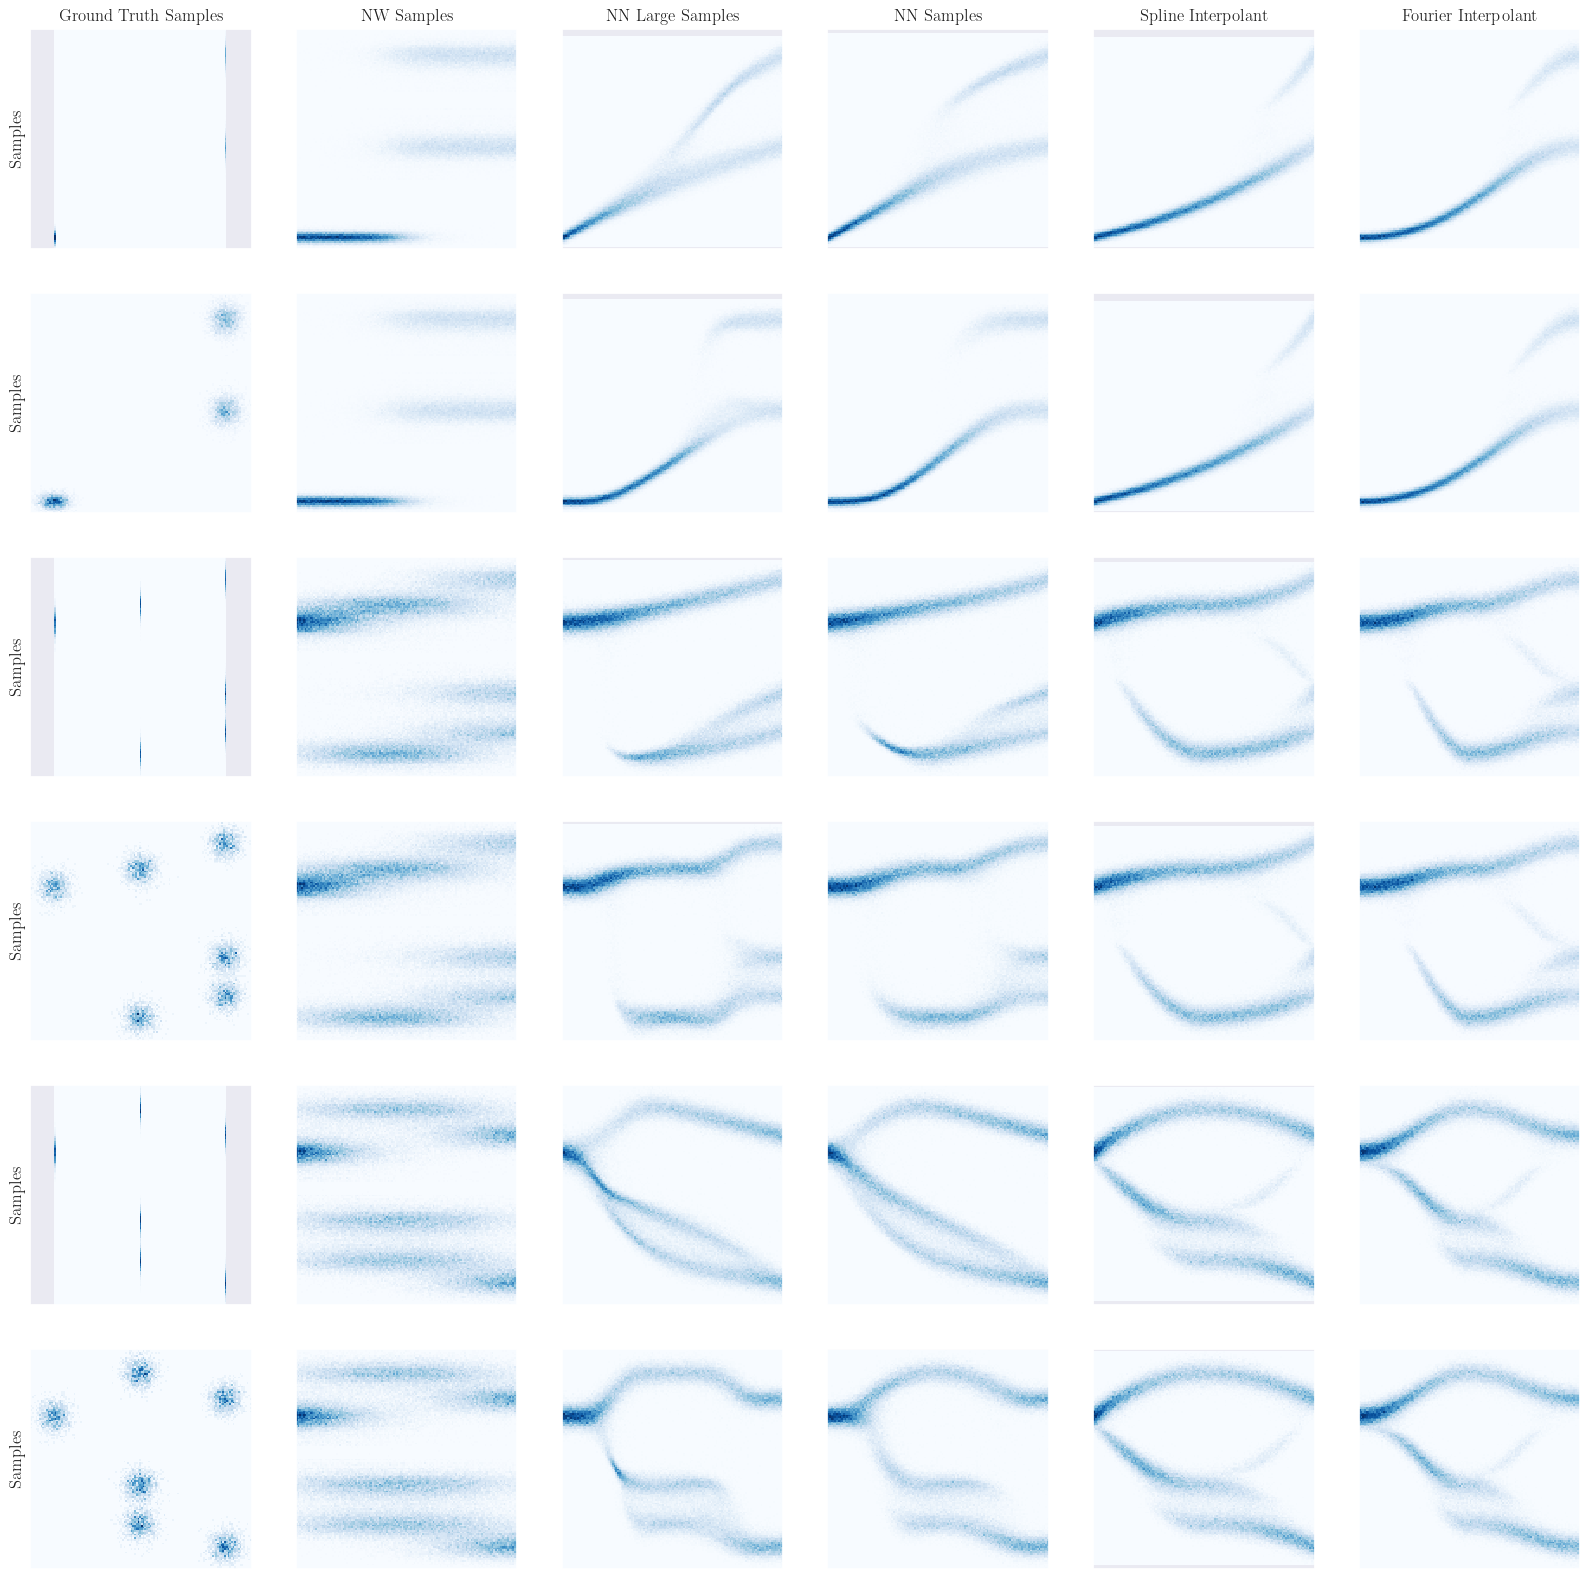

In [19]:
fig, axs = plt.subplots(6, 6, figsize=(20, 20), sharex="col", sharey="row")
plot_low_dim(five_gaussians_data, fig, *axs[3])
plot_low_dim(three_deltas_data, fig, *axs[0], title=True)
plot_low_dim(three_gausians_data, fig, *axs[1])
plot_low_dim(five_deltas_data, fig, *axs[2])
plot_low_dim(five_alt_delta_data, fig, *axs[4])
plot_low_dim(five_alt_gausians_data, fig, *axs[5])
for a in axs[-1][1:]: a.set_yticks([])
for a in axs[:-1]:
    a[0].set_xticks([])
    for ax in a[1:]:
        ax.set_yticks([])
        ax.set_xticks([])

In [65]:
@dataclass
class LowDimMetrics:
    ot: jax.Array
    si: jax.Array
    var: jax.Array

def compute_metrics(rng_key, input : LowDimSamples):
    schedule = DDPMSchedule.make_squaredcos_cap_v2(
        32, 
        prediction_type="epsilon",
        clip_sample_range=2.
    )

    @jax.jit
    def ot(ddim_samples, ddpm_samples):
        ddpm_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddpm_samples)
        ddim_flat = jax.vmap(lambda x: tree.ravel_pytree(x)[0])(ddim_samples)

        geom = pointcloud.PointCloud(
                ddpm_flat, ddim_flat, epsilon=0.005
        )
        prob = linear_problem.LinearProblem(geom)
        solver = sinkhorn.Sinkhorn(max_iterations=8_000)
        out = solver(prob)
        return out.primal_cost
    # reshape (128, -1) to get the zs back
    ddim_samples, ddpm_samples = tree.map(lambda x: x.reshape(128, -1), (input.nn_ddim_samples, input.nn_ddpm_samples))
    # OT between the xs
    ot_costs = jax.vmap(ot)(ddim_samples[1], ddpm_samples[1])

    def si(rng_key, t, sample, samples):
        noised_sample = schedule.add_noise(rng_key, sample[1], t)[0]
        # nw_output = nonparametric.nw_cond_diffuser(
        #     sample[0], samples.nn_ddpm_samples, schedule, nonparametric.log_gaussian_kernel, 0.005
        # )(None, noised_sample, t)
        nw_output = schedule.output_from_denoised(
            noised_sample, t, schedule.compute_denoised(noised_sample, t, samples[1])
        )
        model_output = low_dim_model.apply(input.vars, noised_sample, t - 1, cond=sample[0])
        return npx.linalg.norm(nw_output - model_output)

    def si_t(rng_key, t, samples):
        errs = jax.vmap(si, in_axes=(0, None, 0, None))(
            jax.random.split(rng_key, tree.axis_size(samples)), t, samples, samples
        )
        return npx.mean(errs)

    def si_z(rng_key, samples):
        ts = npx.arange(1, schedule.num_steps + 1)
        return jax.vmap(si_t, in_axes=(0, 0, None))(
            jax.random.split(rng_key, ts.shape[0]), 
            ts, samples
        )
    inconsistency = jax.vmap(si_z)(
        jax.random.split(rng_key, ddpm_samples[0].shape[0]),
        ddpm_samples
    )

    def calc_var(x):
        return npx.mean(npx.square(x - npx.mean(x)))
    var  = jax.vmap(calc_var)(ddpm_samples[1])

    return LowDimMetrics(ot_costs, inconsistency, var)

In [66]:
three_deltas_metrics = compute_metrics(foundry.random.key(42), three_deltas_data)

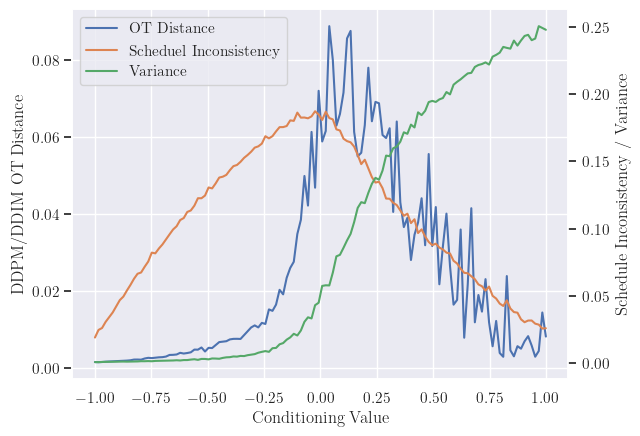

In [69]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
h1, = ax.plot(npx.linspace(-1, 1, three_deltas_metrics.ot.shape[0]), 
        three_deltas_metrics.ot, label="OT Distance", color=colors[0])
ax.set_ylabel("DDPM/DDIM OT Distance")
ax_twin = ax.twinx()
h2, = ax_twin.plot(npx.linspace(-1, 1, three_deltas_metrics.ot.shape[0]), 
             three_deltas_metrics.si.mean(-1), label="Scheduel Inconsistency", color=colors[1])
ax_twin.grid(False)
ax_twin.set_ylabel("Schedule Inconsistency / Variance")

h3, = ax_twin.plot(npx.linspace(-1, 1, three_deltas_metrics.ot.shape[0]),
                   three_deltas_metrics.var, label="Variance", color=colors[2])
ax.set_xlabel("Conditioning Value")
ax.legend(handles=[h1,h2,h3], loc="upper left")
fig.show()

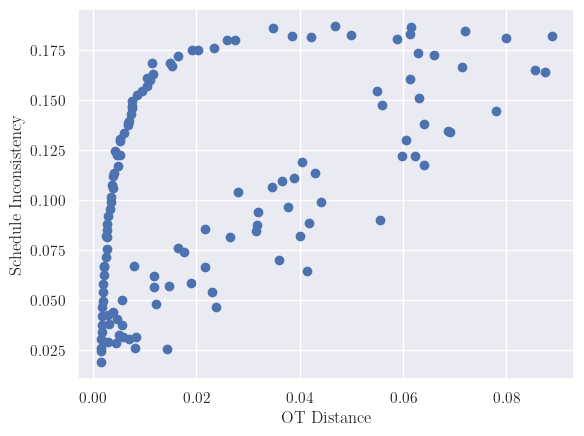

In [71]:
plt.scatter(three_deltas_metrics.ot, three_deltas_metrics.si.mean(-1))
plt.xlabel("OT Distance")
plt.ylabel("Schedule Inconsistency")
plt.show()